In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import collections
import pathlib
import random
import pickle
import cv2
from typing import Dict, Tuple, Sequence
import PIL 
from skimage.color import rgb2lab, lab2rgb

import utils
from utils import make_kmeans_palette, changing_palette, image_palette, centers_to_hexa, viz_color_palette
# Main path
cwd = os.getcwd()

In [2]:
cwd

'/home/src'

In [3]:
!pip3 install colormath
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color 

def rgb_to_cielab(a):
    """
    a is a pixel with RGB coloring
    """
    a1,a2,a3 = a/255

    color1_rgb = sRGBColor(a1, a2, a3);

    color1_lab = convert_color(color1_rgb, LabColor);
    
    final = [color1_lab.lab_l,color1_lab.lab_a,color1_lab.lab_b]

    return final

In [4]:
def centers_to_lab_vectors(centers):
    row,col = centers.shape
    target_palette = np.zeros((row,col))
    for i in range(row):
        target_palette[i,:] = rgb_to_cielab(centers[i,:])

    return np.reshape(target_palette,(row*col,1))

In [5]:
def augment_image(img, title, hue_shift):
    # plt.imshow(img)
    # plt.title(f"Original {title} (in RGB)")
    # plt.show()

    # RGB -> HSV -> hue-shift 
    img_HSV = matplotlib.colors.rgb_to_hsv(img)
    a_2d_index = np.array([[1,0,0] for _ in range(img_HSV.shape[1])]).astype('bool')
    img_HSV[:, a_2d_index] = (img_HSV[:, a_2d_index] + hue_shift) % 1

    new_img = matplotlib.colors.hsv_to_rgb(img_HSV).astype(int)
    # plt.imshow(new_img)
    # plt.title(f"New {title} (in RGB)")
    # plt.show()

    # fixed original luminance
    img = img.astype(np.float) / 255.0
    new_img = new_img.astype(np.float) / 255.0
    ori_img_LAB = rgb2lab(img)
    new_img_LAB = rgb2lab(new_img)
    new_img_LAB[:, :, 0] = ori_img_LAB[:, :, 0]
    new_img_augmented = (lab2rgb(new_img_LAB)*255.0).astype(int)
    # plt.imshow(new_img_augmented)
    # plt.title(f"New {title} (in RGB) with Fixed Luminance")
    # plt.show()
    # plt.close()

    return new_img_augmented

In [6]:
#def viz_color_palette(hexcodes):
#    """
#    visualize color palette
#    """
#    hexcodes = list(hexcodes)
#    while len(hexcodes) < 6:
#        hexcodes = hexcodes + hexcodes
#    hexcodes = hexcodes[:6]
#    
#    palette = []
#    for hexcode in hexcodes:
#        rgb = np.array(list(int(hexcode.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)))
#        palette.append(rgb)
#
#   palette = np.array(palette)[np.newaxis, :, :]
#    return palette


def viz_image(path, image_to_palette: Dict):
    """
    visualize image
    visualize palette (using image_to_palette)
    """
    assert pathlib.Path(path).name in image_to_palette
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    palette = viz_color_palette(image_to_palette[pathlib.Path(path).name])
    
    # visualize image
    plt.imshow(img)
    plt.show()
    
    # visualize color palette
    print(palette.shape)
    plt.imshow(palette)
    # print(palette.shape)
    plt.axis('off')
    plt.show()

    return

### Observando la salida de la función ```viz_color_palette```

In [7]:
#hexcodes = ['#4b46cd','#f2e40c','#133337','#97c1e7','#c3072b','#83a598','#0072e0']
#viz_color_palette(hexcodes)

### Procesando imáagenes reales

In [8]:
# Objective pages: https://www.instagram.com/grafftales/?hl=en
# https://www.design-seeds.com/

In [9]:
# Esto es hermoso
#!pip install instagram-scraper

In [10]:
# Guardando nombre de los archivos
images = glob.glob(cwd+'/grafftales/'+"*.jpg")
filenames = list()
for image in images:
    filenames.append(image)
    
# Guardando las imágenes
images_graffite = [cv2.imread(file) for file in glob.glob(cwd+'/grafftales/'+'/*.jpg')]

In [11]:
len(images_graffite)

829

In [12]:
# Se cae el kernel D:
#images_palette = [cv2.imread(file) for file in glob.glob(cwd+'/colorpalette/'+'/*.jpg')]
#len(images_palette)

### Observando las imágenes: aplicando el shift en una sola imagen

In [13]:
test = images_graffite[100]

In [14]:
test.shape

(639, 639, 3)

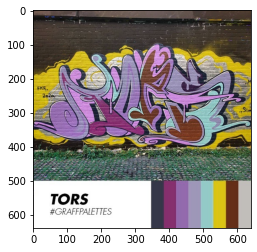

In [15]:
plt.imshow(test)

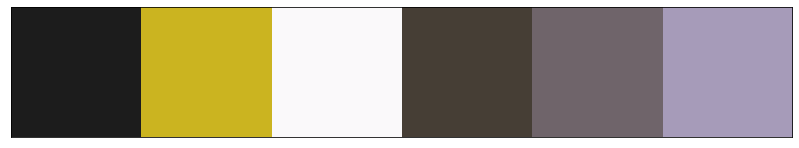

In [16]:
palette = image_palette(make_kmeans_palette(test),cwd+'/palettes/'+'test.png')

In [17]:
#palette.shape

In [18]:
#palette[:,:]

### Misterio por descubrir: paletas en formato hexacode

In [19]:
centers = make_kmeans_palette(test)
print(viz_color_palette(centers))

[[[111 100 105]
  [250 249 250]
  [167 155 185]
  [204 180  32]
  [ 28  28  28]
  [ 70  62  53]]]


In [25]:
print(centers)
print(centers.shape)
print(rgb_to_cielab(centers[0,:]))
print(centers_to_lab_vectors(centers).shape)

[[0.4354136  0.3920191  0.4118841 ]
 [0.9804094  0.9763012  0.98038757]
 [0.6536931  0.6078894  0.7274077 ]
 [0.799728   0.70604986 0.12598881]
 [0.10826096 0.10931042 0.10836294]
 [0.2742231  0.24191421 0.2081057 ]]
(6, 3)
[0.11040445709490854, 0.014108289602327018, -0.0035448736361132216]
(18, 1)


In [26]:
hue_shift = random.random()
augmented_image = augment_image(test, "Image", hue_shift)

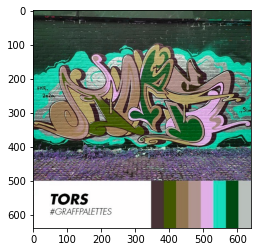

In [27]:
plt.imshow(augmented_image)

In [28]:
image_palette(make_kmeans_palette(augmented_image),cwd+'/palettes/'+'test_new.png')

### Modificando el tamaño de las imágenes

In [29]:
def resize_image(img):
# Tamaño propuesto en el paper
    SIZE = (288,432)    
    img_pil = PIL.Image.fromarray(img).resize(SIZE, resample=PIL.Image.BILINEAR)    
    return img_pil

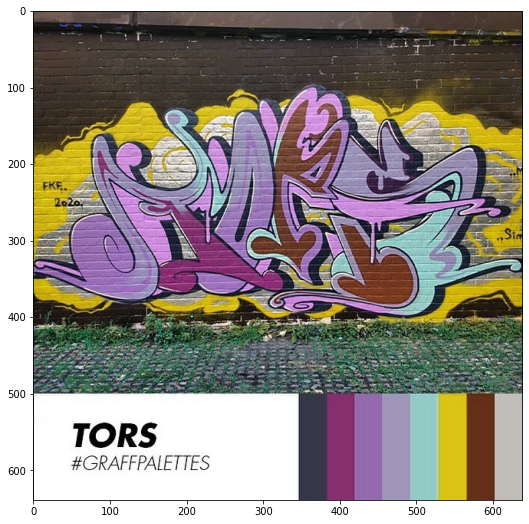

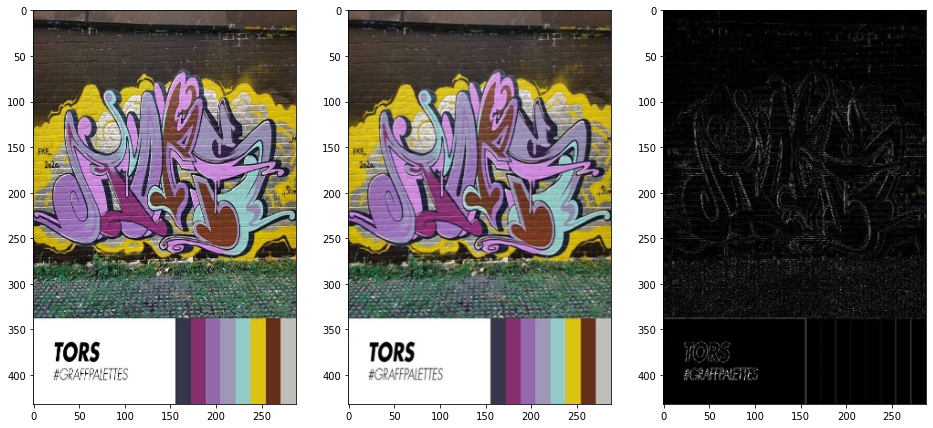

In [30]:
# Display the initial image
plt.figure(figsize=(16,9))
plt.imshow(test)
plt.show()
plt.close()

# Tamaño propuesto en el paper
SIZE = (288,432)

# resize the image in two different ways
img_cv2 = cv2.resize(test, dsize=SIZE, interpolation=cv2.INTER_LINEAR)
img_pil = PIL.Image.fromarray(test).resize(SIZE, resample=PIL.Image.BILINEAR)

# get the difference image and normalize it
diff = np.abs(img_cv2.astype(np.float32) - img_pil)
diff /= diff.max() or 1

# display results
fig, axs = plt.subplots(1, 3, figsize=(16, 9))
axs[0].imshow(img_cv2)

# El resize con PIL tiene mejor resolucion!
axs[1].imshow(img_pil)
axs[2].imshow(diff)
plt.show()
plt.close()

### Color Shift: por algun motivo esta estructura para recorrer los datos no funciona correctamente, no es primera vez que me ocurre trabajando localmente en jupiter. 

In [31]:
### Parte mas importante del codigo de almacenamiento!

### fija un shift y guarda la imagen origina, la variada y la nueva paleta.

#    hue_shift = random.random()
#    print(hue_shift)
#    augmented_image = augment_image(img, "Image", hue_shift)
#    augmented_palette = augment_image(palette, "Palette", hue_shift)


### guarda en train la imagen original y su paleta
### guarda la imagen nueva y su paleta

#    cv2.imwrite(f'data/train/input/{path.name}', img)
#    pickle.dump(palette, open(f'data/train/old_palette/{path.stem}.pkl', 'wb'))
#    cv2.imwrite(f'data/train/output/{path.name}', augmented_image)
#    pickle.dump(augmented_palette, open(f'data/train/new_palette/{path.stem}.pkl', 'wb'))

### Diseñando el pipeline para construir la base de datos

1 - Leo la imagen y mantengo una copia.

2 - Extraigo la paleta.

3 - Vario la imagen y mantengo una copia.

4 - Extraigo la paleta nueva.

5 - Realizo el resize de las dos imágenes.

6 - Almaceno la información utilizando los mismos nombres de los directorios.